## Data load

In [ ]:
import pandas as pd
import numpy as np

%run "classes.ipynb"

def load_data():
    df = pd.read_csv('Tweets.csv')
    df = df[['text', 'airline_sentiment']]
    return df

df = load_data()

## Basic visualisation

### Number of observations in the classes

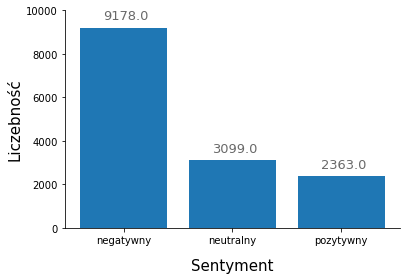

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

sentiment_count = df['airline_sentiment'].value_counts()
Index = [1, 2, 3]
plt.figure(figsize=(6,4))
plt.bar(Index, sentiment_count)
plt.xticks(Index, ['negatywny', 'neutralny', 'pozytywny'], rotation=0, fontsize=10)
plt.ylabel('Liczebność', fontsize=15)
plt.xlabel('Sentyment', fontsize=15, labelpad=13)
plt.ylim(0, 10000)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i in ax.patches:
    # set positions of displayed numbers
    ax.text(i.get_x()+.21, i.get_height()+400,
            i.get_height(), fontsize=13, color='dimgrey')

### Length of tweets after tokenization and basic cleaning

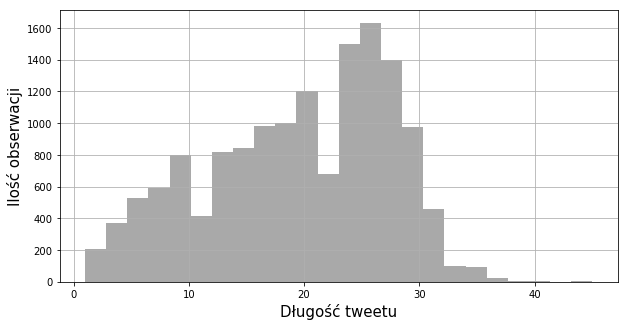

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

X, y = df.text, df.airline_sentiment
X = CleanText(stemming_apply = False, stopwords_apply= False).fit_transform(X)

tweets_len = X.apply(len)
tweets_len.hist(bins=24, figsize=(10, 5), color='darkgrey')
plt.xlabel('Długość tweetu', fontsize=15)
plt.ylabel('Ilość obserwacji', fontsize=15)
plt.show()

### Comparision of performance of 3 best feedforward NN (with 3-fold cross-validation)

([<matplotlib.axis.XTick at 0x1bd16ed5710>,
 <a list of 3 Text xticklabel objects>)

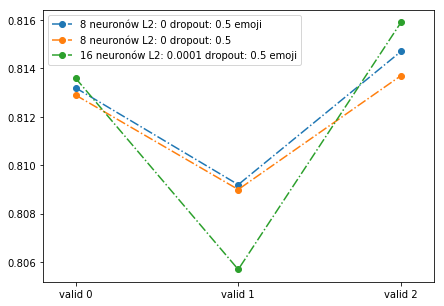

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

dane = pd.DataFrame()
dane['8 neuronów L2: 0 dropout: 0.5 emoji'] = [0.8132, 0.8092, 0.8147]
dane['8 neuronów L2: 0 dropout: 0.5'] = [0.8129, 0.809, 0.8137]
dane['16 neuronów L2: 0.0001 dropout: 0.5 emoji'] = [0.8136, 0.8057, 0.8159]

dane.plot( style = '-.', marker = 'o', figsize = (7, 5))
plt.xlim((-0.2, 2.2))
plt.xticks(range(3), ('valid 0', 'valid 1', 'valid 2'))

## Build report

In [ ]:
"""
Reports store the information about models built during tuning, including:
architecture, hiperparameters, preprocessing and the performance during 3-fold cross-falidation.
Helps with analysis and comparing the models.

Functions:
    build_model_report - builds model report based on input information, return a report in form of dataframe.
    update_report_model - updates/concatenates the reports
    update_report_model_on_disk_xlsx - updates the report on disk
"""



def build_model_report(model_destription_str, params_dict, models_train_history_dict):
    """
    Builds model report based on input information, 
    return a report in form of dataframe.
    
    model_destription_str (str) - own model destription/ comment
    params_dict (dict) - dictionary of params setting
    models_train_history_dict (dict) - dictionary of model performance evaluation, 
        consist of keys: 1, 2, .. n (for every fold of cross-validation) which are dictionaries from
        model.history.history after model fitting in keras + 'acc_best' and 'val_acc_best' for epoch 
        with best accuracy on validation dataset. 
    """  
  
    # Aggregate data into the lists
    acc = []
    val_acc = []
    time = []
    for fold in models_train_history_dict.keys():
        acc.append(models_train_history_dict[fold]['acc_best'])
        val_acc.append(models_train_history_dict[fold]['val_acc_best'])
        time.append(models_train_history_dict[fold]['time'])
        
    models_train_history_dict['acc'] = acc
    models_train_history_dict['val_acc'] = val_acc
    models_train_history_dict['mean_time'] = np.round(np.mean(time), 2)
    
    # Build report
    report = pd.DataFrame()
    report.loc[0, 'description' ] = model_destription_str
    report.loc[0, 'params' ] = str( params_dict )   
        
    report.loc[0, 'score_valid'] = str(dict(enumerate(models_train_history_dict['val_acc'])))
    report.loc[0, 'score_train'] = str(dict(enumerate(models_train_history_dict['acc'])))
    
    report.loc[0, 'valid_mean' ] = np.round(np.mean(models_train_history_dict['val_acc']), 4)
    report.loc[0, 'valid_std' ] = np.round(np.std(models_train_history_dict['val_acc']), 4)
    report.loc[0, 'train_mean' ] = np.round(np.mean(models_train_history_dict['acc']), 4)
    report.loc[0, 'train_std' ] = np.round(np.std(models_train_history_dict['acc']), 4)
    
    # accuracy for every epoch
    for fold in list(models_train_history_dict.keys())[:-3]:    
        report.loc[0, 'score_valid_' + str(fold) ] = str(dict(enumerate(models_train_history_dict[ fold ]['val_acc'])))
        report.loc[0, 'score_train_' + str(fold) ] = str(dict(enumerate(models_train_history_dict[ fold ]['acc'])))
    
    report.loc[0, 'mean_time' ] = models_train_history_dict['mean_time']
    
    return report

def update_report_model(old_report, new_report):
    """Updates/concatenates the reports"""
    return pd.concat([old_report, new_report])
    
def update_report_model_on_disk_xlsx( report_to_add ):
    """Updates the report on disk"""
    report_modele = pd.read_excel('report_modele.xls')
    report_updated = pd.concat([report_modele, report_to_add])
    report_updated = report_updated[ report_modele.columns ]
    report_updated.to_excel( 'report_modele.xls', index = False)
    
    return report_updated

# Regression

## Best set of parameters

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer

import emoji

def extract_emojis(tweet):
    emoji_tweet = ' '.join(emoji.UNICODE_EMOJI_ALIAS[c] for c in tweet if c in emoji.UNICODE_EMOJI)
    if emoji_tweet == '':
        emoji_tweet = 'empty'

    return emoji_tweet



pipe_CountVectorizer = Pipeline([

    ('clean_embedding', Pipeline([
        ('CleanText', CleanText(stemming_apply = False, tokenize_apply = False, stopwords_apply= False)),
        ('union', FeatureUnion([
            ('tweet_length', FunctionTransformer(lambda X: np.array(X.apply(len)).reshape(-1,1), validate = False)),
            ('number_of_mentions', FunctionTransformer(lambda X: 
                                                       np.array(X.apply(lambda tweet: len(re.findall('@', tweet))-1)).reshape(-1,1), validate = False) ),
            ('CreateEmbeddings', CountVectorizer(ngram_range = (1,2)))
        ]))
    ]))

])    



# X, y = df.text, df.airline_sentiment

# pipe_CountVectorizer = Pipeline([
#     ('union', FeatureUnion([
#         ('clean_embedding', Pipeline([
# #                 ('CleanText', CleanText(stemming_apply = False, tokenize_apply = False, stopwords_apply= False)),
#                 ('union', FeatureUnion([
#                     ('tweet_length', FunctionTransformer(lambda X: np.array(X.apply(len)).reshape(-1,1), validate = False)),
#                     ('number_of_mentions', FunctionTransformer(lambda X: 
#                                                                np.array(X.apply(lambda tweet: len(re.findall('@', tweet))-1)).reshape(-1,1), validate = False) ),
#                     ('CreateEmbeddings', CountVectorizer(ngram_range = (1,2)))
#                 ]))
#         ])),
#         ('emoticons', Pipeline([
#             ('emoji_ONEHOT', FunctionTransformer(lambda X:
#                                             X.apply(lambda tweet: ''.join(set(extract_emojis(tweet).split()))), validate=False)),
#             ('CreateEmbeddings', CountVectorizer())
#         ]))        
#     ]))
# ])

## Model

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

X, y = df.text, df.airline_sentiment
lr = LogisticRegression(penalty = 'l2', C = 1.25)
results = pd.DataFrame({'train': [0.0], 'valid' : [0.0]})

skf = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
for train_index, test_index in skf.split(X, y):
    X_train_kfold, X_test_kfold = X[train_index], X[test_index]
    y_train_kfold, y_test_kfold = y[train_index], y[test_index]
    
    X_train_CV = pipe_CountVectorizer.fit_transform(X_train_kfold)
    X_test_CV = pipe_CountVectorizer.transform(X_test_kfold) 
    lr.fit(X_train_CV, y_train_kfold)
    
    results.loc[len(results)] = [lr.score(X_train_CV, y_train_kfold),
                                              lr.score(X_test_CV, y_test_kfold)]
    

In [36]:
results[1:], results[1:].mean()

(      train     valid
 1  0.993339  0.811719
 2  0.992008  0.806148
 3  0.992214  0.805288, train    0.992521
 valid    0.807718
 dtype: float64)

# Feedforward neural network

In [50]:
"""
Builds several Feedforward NN architectures, 
stores data about performance in report
"""

import gc
from timeit import default_timer as timer
import keras.backend as K
from keras.initializers import glorot_normal
from keras.layers import Dense, Input, Activation, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras import regularizers
from sklearn.model_selection import StratifiedKFold

import easygui as e
import winsound

from numpy.random import seed
seed(0)
from tensorflow import set_random_seed
set_random_seed(0)

X, y = df.text, df.airline_sentiment
lb = LabelBinarizer().fit(y)

# number of models to build (architectures)
num_random_arch = 16

hidden_layers_list = [4, 16, 32]
dropout_list = [ 0, 0.35, 0.5]
l2_list = [0, 0.0001, 0.0005, 0.001]
activation_list = ['tanh', 'relu']


param_tuning_list = zip(np.random.choice(hidden_layers_list, num_random_arch),
                       np.random.choice(hidden_layers_list+[0, 0], num_random_arch),
                        np.random.choice(dropout_list, num_random_arch),
                        np.random.choice(dropout_list, num_random_arch),
                        np.random.choice(l2_list, num_random_arch),
                        np.random.choice(l2_list, num_random_arch),
                        np.random.choice(activation_list, num_random_arch),
                        np.random.choice(activation_list, num_random_arch)
                       )

 
for h1, h2, dropout_l1, dropout_l2, l2_power1, l2_power2, \
        activation_func1, activation_func2 in param_tuning_list:
        
    gc.collect()

    models_train_history_dict = {} # for report purpose
    skf = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        gc.collect()
        start = timer()

        # preprocessing 
        X_train_kfold, X_test_kfold = X[train_index], X[test_index]
        y_train_kfold, y_test_kfold = y[train_index], y[test_index]

        X_train_CV = pipe_CountVectorizer.fit_transform(X_train_kfold)
        X_test_CV = pipe_CountVectorizer.transform(X_test_kfold) 

        y_train_kfold = lb.transform(y_train_kfold)
        y_test_kfold = lb.transform(y_test_kfold)

        # model architecture
        input_still = Input((X_train_CV.shape[1],))                
        Z = Dense(h1, name = "hidden_layer1", kernel_initializer=glorot_normal(seed=0)
                  , kernel_regularizer=regularizers.l2(l2_power1))(input_still)
        Z = Dropout(dropout_l1, noise_shape=None, seed=0)(Z)
        Z = Activation(activation_func1)(Z)

        if h2 > 0:
            Z = Dense(h2, name = "hidden_layer2", kernel_initializer=glorot_normal(seed=0)
                  , kernel_regularizer=regularizers.l2(l2_power2))(Z)
            Z = Dropout(dropout_l2, noise_shape=None, seed=0)(Z)
            Z = Activation(activation_func2)(Z)


        Z = Dense(3, name = "output_layer", kernel_initializer=glorot_normal(seed=0))(Z)
        Z = Activation('softmax')(Z)


        model = Model(inputs = [input_still], outputs = [Z])
        optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, decay = 1e-3,)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        model.fit([ X_train_CV.toarray()], y_train_kfold, epochs = 8, batch_size = 32, shuffle=False, 
                validation_data = ([X_test_CV.toarray()], y_test_kfold))

        # for futher use (report)
        model_history = model.history.history
        model_history['acc'] = [round(val, 4) for val in model_history['acc']]
        model_history['val_acc'] = [round(val, 4) for val in model_history['val_acc']]

        model_history['val_acc_best'] = max(model_history['val_acc'])
        model_history['acc_best'] = model_history['acc'][model_history['val_acc'].index(model_history['val_acc_best'])]

        end = timer()
        model_history['time'] = end - start

        models_train_history_dict[str(fold)] = model_history


    params_dict = { 'layer1_nodes' : h1,
                   'layer2_nodes' : h2,
                    'layer1_dropout' : dropout_l1,
                    'layer2_dropout' : dropout_l2,
                    'l2_power1' : l2_power1,
                    'l2_power2' : l2_power2,
                    'activation_func1' : activation_func1,
                    'activation_func2' : activation_func2
                  } 
    model_destription_str = 'CleanText without stopwords, additional features: tweet_length, number_of_mentions'
    single_model_report = build_model_report( model_destription_str, params_dict, models_train_history_dict  )

    if 'all_models_report' not in globals():
        all_models_report = single_model_report
    else:
        all_models_report = update_report_model(all_models_report, single_model_report)

    while True:
        try:
            all_models_report.to_excel( 'report_modele.xls', index = False)
            break
        except:
            e.msgbox("Zamknij plik report_modele.xls", "Error")
    gc.collect()

winsound.Beep(1500, 3000)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 9759 samples, validate on 4881 samples
Epoch 1/8
9759/9759 [==============================] - 58s 6ms/step - loss: 0.8848 - acc: 0.6275 - val_loss: 0.8087 - val_acc: 0.6449
Epoch 2/8
9759/9759 [==============================] - 31s 3ms/step - loss: 0.8027 - acc: 0.6637 - val_loss: 0.6958 - val_acc: 0.6921
Epoch 3/8
9759/9759 [==============================] - 31s 3ms/step - loss: 0.7535 - acc: 0.6874 - val_loss: 0.7436 - val_acc: 0.6829
Epoch 4/8
9759/9759 [==============================] - 41s 4ms/step - loss: 0.7238 - acc: 0.7007 - val_loss: 0.6880 - val_acc: 0.7447
Epoch 5/8
9759/9759 [==============================] - 29s 3ms/step - loss: 0.6798 - acc: 0.7143 - val_loss: 0.6837 - val_acc: 0.7455
Epoch 6/8
9759/9759 [==============================] - 35s 4ms/step - loss: 0.6219 - acc: 0.7391 - val_loss: 0.7538 - val_acc: 0.7425
Epoch 7/8
9759/9759 [==============================] - 29s 3ms/step - loss:


KeyboardInterrupt



# Recurrent neural nets

## Some preprocessing pipelines

In [2]:
"""
Some preprocessing pipelines
"""

from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
import emoji

import winsound

max_length = 32


# tags in one hot representation
pipe_OneHotTags = Pipeline([
    ('tagging', Tag(only_tags=True)),
    ('flattening_list', FunctionTransformer(itertools.chain.from_iterable, validate = False)),
    ('to_list', FunctionTransformer(list, validate = False)),
    ('OneHot', CustomBinarizer())
])

# word embeddings
pipe_WordEmbeddings = Pipeline([
    ('CreateEmbeddings', embeddings( emb_source = 'own', emb_size = 400, emb_type = 'each')),    
    ('reshape_to_2D', FunctionTransformer(lambda X: X.reshape(int(X.shape[0]*X.shape[1]), -1), validate = False))
])
    
# word sentiment features
pipe_SentiFeatures = Pipeline([
    ('tagging', Tag(only_tags=False)),
    ('cc', SentiFeatures(only_pos_neg = False)),
    ('reshape_to_2D', FunctionTransformer(lambda X: X.reshape(int(X.shape[0]*X.shape[1]), -1), validate = False))
])


pipe1 = Pipeline([
    ('CleanText', CleanText(stemming_apply = False, stopwords_apply= False)),
    ('FixLength', FixLength(max_length = max_length)),
    ('union', FeatureUnion([ 
        ('embedding', Pipeline([
            ('lemmatize', FunctionTransformer(lambda X: X.apply(lambda tweet:
                [WordNetLemmatizer().lemmatize(t) for t in tweet]), validate = False)), #word_tokenize(tweet)]))),
            ('embedding', pipe_WordEmbeddings),
        ]))
    ])),
    ('reshape_to_3D', FunctionTransformer(lambda X: X.reshape(-1, max_length ,X.shape[1])))
    
])

pipe2 = Pipeline([
    ('CleanText', CleanText(stemming_apply = False, stopwords_apply= False)),
    ('FixLength', FixLength(max_length = max_length)),
    ('union', FeatureUnion([     
        ('embedding', Pipeline([
            ('lemmatize', FunctionTransformer(lambda X: X.apply(lambda tweet:
                [WordNetLemmatizer().lemmatize(t) for t in tweet]), validate = False)), #word_tokenize(tweet)]))),
            ('embedding', pipe_WordEmbeddings),
        ]))
        ('sentiment_features', pipe_SentiFeatures)
    ])),
    ('reshape_to_3D', FunctionTransformer(lambda X: X.reshape(-1, max_length ,X.shape[1])))
    
])

pipe3 = Pipeline([
    ('CleanText', CleanText(stemming_apply = False, stopwords_apply= False)),
    ('FixLength', FixLength(max_length = max_length)),
    ('union', FeatureUnion([    
        ('embedding', Pipeline([
            ('lemmatize', FunctionTransformer(lambda X: X.apply(lambda tweet:
                [WordNetLemmatizer().lemmatize(t) for t in tweet]), validate = False)), #word_tokenize(tweet)]))),
            ('embedding', pipe_WordEmbeddings),
        ])),
        ('tags_ONEHOT', pipe_OneHotTags)
    ])),
    ('reshape_to_3D', FunctionTransformer(lambda X: X.reshape(-1, max_length ,X.shape[1])))
    
])

pipe4 = Pipeline([
    ('CleanText', CleanText(stemming_apply = False, stopwords_apply= False)),
    ('FixLength', FixLength(max_length = max_length)),
    ('union', FeatureUnion([
        ('embedding', Pipeline([
            ('lemmatize', FunctionTransformer(lambda X: X.apply(lambda tweet:
                [WordNetLemmatizer().lemmatize(t) for t in tweet]), validate = False)), #word_tokenize(tweet)]))),
            ('embedding', pipe_WordEmbeddings),
        ])),
        ('sentiment_features', pipe_SentiFeatures),
        ('tags_ONEHOT', pipe_OneHotTags)
    ])),
    ('reshape_to_3D', FunctionTransformer(lambda X: X.reshape(-1, max_length ,X.shape[1])))
    
])


X, y = df.text, df.airline_sentiment
lb = LabelBinarizer().fit(y)

In [14]:
"""
Some pipelines: to check how standarization of length of tweets
and size of embeddings influence the performance
"""
import itertools

pipe_list = []
emb_size_list = [150, 250, 400]
max_length_list = [24, 32]

iter_list = list( itertools.product(emb_size_list, max_length_list) )

for emb_size, max_length in iter_list:
    # word embeddings
    pipe_WordEmbeddings = Pipeline([
        ('CreateEmbeddings', embeddings( emb_source = 'own', emb_size = emb_size, emb_type = 'each')),    
        ('reshape_to_2D', FunctionTransformer(lambda X: X.reshape(int(X.shape[0]*X.shape[1]), -1), validate = False))
    ])

    pipe = Pipeline([
        ('CleanText', CleanText(stemming_apply = False, stopwords_apply= False)),
        ('FixLength', FixLength(max_length = max_length)),
        ('union', FeatureUnion([

            ('embedding', Pipeline([
                ('lemmatize', FunctionTransformer(lambda X: X.apply(lambda tweet:
                    [WordNetLemmatizer().lemmatize(t) for t in tweet]), validate = False)), #word_tokenize(tweet)]))),
                ('embedding', pipe_WordEmbeddings),
            ])),

            ('sentiment_features', pipe_SentiFeatures),
            ('tags_ONEHOT', pipe_OneHotTags)
        ])),
        ('reshape_to_3D', FunctionTransformer(lambda X: X.reshape(-1, max_length ,X.shape[1])))

    ])

    pipe_list.append((pipe, emb_size, max_length))

## Save preprocessed data sets (to use in cross validation)

In [15]:
"""
Preprocess the data (using first pipe from pipe_list),
to spare time doing it every time again and again (in cross-validation)
when tuning hiperparameters of model

result: kfold_list cointaining preprocessed data sets for every fold
"""

from sklearn.model_selection import StratifiedKFold

X, y = df.text, df.airline_sentiment
lb = LabelBinarizer().fit(y)

X_train_kfold_list = []
X_test_kfold_list = []
y_train_kfold_list = []
y_test_kfold_list = []

(pipe, emb_size, max_length) = pipe_list[0]

skf = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train_kfold, X_test_kfold = X[train_index], X[test_index]
    y_train_kfold, y_test_kfold = y[train_index], y[test_index]

    X_train_kfold_list.append( pipe.fit_transform(X_train_kfold) )
    X_test_kfold_list.append( pipe.transform(X_test_kfold) )
    y_train_kfold_list.append(lb.transform(y_train_kfold))
    y_test_kfold_list.append(lb.transform(y_test_kfold))
    
kfold_list = list(zip(X_train_kfold_list, X_test_kfold_list, y_train_kfold_list, y_test_kfold_list))

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:111: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:111: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:111: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:111: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:111: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Program Files\Anaconda\lib\

## Model

In [16]:
"""
Recurrent neural nets and preprocessing tuning
"""

import keras.backend as K
from keras.initializers import glorot_normal
from keras.layers import Dense, Input, Activation, Dropout, SimpleRNN, GRU, LSTM
from keras.models import Model
from keras.optimizers import Adam
from keras import regularizers
from sklearn.model_selection import StratifiedKFold

import gc
from timeit import default_timer as timer
import easygui as e
import itertools

from numpy.random import seed
seed(0)
from tensorflow import set_random_seed
set_random_seed(0)


hidden_layers_list = [8]
reccurent_units = [ 'GRU']
dropout_list = [0.5]
l2_list = [0]

param_tuning_list = itertools.product(hidden_layers_list, reccurent_units, dropout_list, l2_list)
for (pipe, emb_size, max_length) in pipe_list:
   
    print('########################')
    print(emb_size, max_length)
    print('########################')
    
    for h1, reccurent_unit, dropout_l1, l2_power1 in param_tuning_list:
            
        seed(0)
        set_random_seed(0)      
        gc.collect()
        
        models_train_history_dict = {} # for report purpose
        for fold, (X_train_kfold, X_test_kfold, y_train_kfold, y_test_kfold) in enumerate(kfold_list):
            gc.collect()
            start = timer()

            # Architecture
            input_seq = Input((X_train_kfold.shape[1], X_train_kfold.shape[2]))   
            
            if reccurent_unit == 'SimpleRNN':
                Z = SimpleRNN(h1, return_sequences = False, kernel_initializer=glorot_normal(seed=0))(input_seq)
                Z = Dropout(dropout_l1, noise_shape=None, seed=0)(Z)
                
            if reccurent_unit == 'LSTM':
                Z = LSTM(h1, return_sequences = False, kernel_initializer=glorot_normal(seed=0),
                         recurrent_regularizer = regularizers.l2(l2_power))(input_seq)
                Z = Dropout(dropout_l1, noise_shape=None, seed=0)(Z)
                
            if reccurent_unit == 'GRU':
                Z = GRU(h1, return_sequences = False, kernel_initializer=glorot_normal(seed=0),
                       recurrent_regularizer = regularizers.l2(l2_power))(input_seq)
                Z = Dropout(dropout_l1, noise_shape=None, seed=0)(Z)
              

            Z = Dense(3, name = "output_layer", kernel_initializer=glorot_normal(seed=0))(Z)
            Z = Activation('softmax')(Z)

            model = Model(inputs = [input_seq], outputs = [Z])
            optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay = 1e-4,)
            model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

            model.fit([ X_train_kfold], y_train_kfold, epochs = 20, batch_size = 32, shuffle=False, 
                    validation_data = ([X_test_kfold], y_test_kfold))

            model_history = model.history.history
            model_history['acc'] = [round(val, 4) for val in model_history['acc']]
            model_history['val_acc'] = [round(val, 4) for val in model_history['val_acc']]

            model_history['val_acc_best'] = max(model_history['val_acc'])
            model_history['acc_best'] = model_history['acc'][model_history['val_acc'].index(model_history['val_acc_best'])]

            end = timer()
            model_history['time'] = end - start

            models_train_history_dict[str(fold)] = model_history

        # for futher use (report)
        max_length = pipe.get_params()['FixLength__max_length']
        emb_size = pipe.get_params()['union__embedding__embedding'].get_params()['CreateEmbeddings__emb_size']

        params_dict = { 'layer1_nodes' : h1,
                       'reccurent_unit' : reccurent_unit,
                        'layer1_dropout' : dropout_l1,
                        'l2_power' : l2_power
                      } 
        model_destription_str = 'embeddings method skip-gram ' +  str(emb_size)  + ' length ' + str(max_length)
        single_model_report = build_model_report( model_destription_str, params_dict, models_train_history_dict  )

        if 'all_models_report' not in globals():
            all_models_report = single_model_report
        else:
            all_models_report = update_report_model(all_models_report, single_model_report)

        while True:
            try:
                all_models_report.to_excel( 'report_modele.xls', index = False)
                break
            except:
                e.msgbox("Zamknij plik report_modele.xls", "Error")
        gc.collect()
        
        
winsound.Beep(1500, 1000)

########################
150 32
########################
########################
32 0 0
########################
Train on 9759 samples, validate on 4881 samples
Epoch 1/20
9759/9759 [==============================] - 21s 2ms/step - loss: 0.8898 - acc: 0.6196 - val_loss: 0.8275 - val_acc: 0.6427
Epoch 2/20
9759/9759 [==============================] - 8s 852us/step - loss: 0.7179 - acc: 0.6959 - val_loss: 0.6468 - val_acc: 0.7414
Epoch 3/20
9759/9759 [==============================] - 8s 859us/step - loss: 0.6151 - acc: 0.7575 - val_loss: 0.6056 - val_acc: 0.7595
Epoch 4/20
9759/9759 [==============================] - 8s 837us/step - loss: 0.5704 - acc: 0.7838 - val_loss: 0.5378 - val_acc: 0.7851
Epoch 5/20
9759/9759 [==============================] - 8s 836us/step - loss: 0.5433 - acc: 0.7939 - val_loss: 0.5224 - val_acc: 0.7875
Epoch 6/20
9759/9759 [==============================] - 8s 833us/step - loss: 0.5182 - acc: 0.8092 - val_loss: 0.5298 - val_acc: 0.7953
Epoch 7/20
9759/9759 [=

9761/9761 [==============================] - 9s 881us/step - loss: 0.4106 - acc: 0.8567 - val_loss: 0.5363 - val_acc: 0.8063
Epoch 18/20
9761/9761 [==============================] - 8s 861us/step - loss: 0.4014 - acc: 0.8608 - val_loss: 0.5494 - val_acc: 0.8071
Epoch 19/20
9761/9761 [==============================] - 7s 728us/step - loss: 0.3879 - acc: 0.8672 - val_loss: 0.5642 - val_acc: 0.8043
Epoch 20/20
9761/9761 [==============================] - 9s 925us/step - loss: 0.3814 - acc: 0.8712 - val_loss: 0.5713 - val_acc: 0.8059
